In [3]:
import os
import pickle
import multiprocessing
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import xgboost as xgb


from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA, FastICA

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, cross_val_predict

color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_columns = 100

from subprocess import check_output

from pyfm import pylibfm
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

%load_ext autotime

/home/subaevdi/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

feat_all = train.columns[2:]
feat_categ = train.dtypes.index[train.dtypes == 'object']
feat_not_uniq = ['X289',
 'X235',
 'X347',
 'X268',
 'X11',
 'X107',
 'X233',
 'X330',
 'X290',
 'X293',
 'X297',
 'X93']

feat_numb = list(set(feat_all) - set(feat_categ) - set(feat_not_uniq))


time: 392 ms


In [5]:
train['test'] = 0
test['test'] = 1

df = pd.concat([train, test], axis=0)
y = train.y
df = df.drop(["ID", "y"], axis=1)
print("Train shape : ", train.shape)
print("Test shape : ", test.shape)

ix_train = df.test == 0
ix_test = df.test == 1

Train shape :  (4209, 379)
Test shape :  (4209, 378)
time: 90.2 ms


In [6]:
for col in feat_categ:
    df[col] = LabelEncoder().fit_transform(df[col])
X = OneHotEncoder().fit_transform(df[feat_categ])

feat_ohe = ['ohe_' + str(i) for i in np.arange(X.shape[1])]
t = pd.DataFrame(X.todense(), columns=feat_ohe, index=df.index)
df = pd.concat( [df, t] , axis=1)

time: 114 ms


In [7]:
def pickle_check_model(predictors, model_file, bremove = False):
    model_file = './../tmp/' + model_file
    if bremove and os.path.isfile(model_file):
        print("Removing old file")
        os.remove(model_file)
    if not os.path.isfile(model_file):
        print("Make grid search...")
        model = check_model(predictors)

        with open(model_file, 'wb') as f:
            pickle.dump(model, f)
    else:
        with open(model_file, 'rb') as f:
            print("Load from file...")
            model = pickle.load(f)
    print(model.best_score_)
    print(model.best_params_)
    return model

time: 8.28 ms


In [8]:
def check_model(predictors):
    classifier = lambda: SGDRegressor(
        loss='squared_loss',
        penalty='elasticnet',
        alpha=0.0005,
        l1_ratio=0.15,
        fit_intercept=True,
        n_iter=5,
        shuffle=True,
        verbose=0, epsilon=0.1, random_state=42, learning_rate='invscaling',
        eta0=0.01, power_t=0.25, warm_start=False, average=False)
    

    model = Pipeline(steps=[
        #('ss', StandardScaler()),
        ('en', classifier())
    ])

    parameters = {
        'en__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.02, 0.1, 0.5, 0.6, 0.7, 0.9, 1],
        'en__l1_ratio': [0, 0.001, 0.01, 0.1, 0.3, 0.5, 0.75, 0.9, 1]
    }
    #parameters = {
    #    'en__alpha': [0.00001, 0.0001],
    #    'en__l1_ratio': [0, 0.0001, 0.001]
    #}

    folder = KFold(n_splits=5, shuffle=True, random_state=42)
    
    grid_search = GridSearchCV(
        model, 
        parameters,
        scoring='r2',
        cv=folder, 
        n_jobs=-1, 
        verbose=1)
    grid_search = grid_search.fit(df[ix_train][predictors], 
                                  y)
    
    return grid_search
gs = check_model(feat_numb)

Fitting 5 folds for each of 99 candidates, totalling 495 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 488 out of 495 | elapsed:   23.3s remaining:    0.3s


time: 23.8 s


[Parallel(n_jobs=-1)]: Done 495 out of 495 | elapsed:   23.5s finished


In [9]:
t = pickle_check_model(feat_numb, '4_model.pkl', bremove=False)

Load from file...
0.511579804396
{'en__alpha': 1e-05, 'en__l1_ratio': 1}
time: 24.4 ms


/home/subaevdi/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


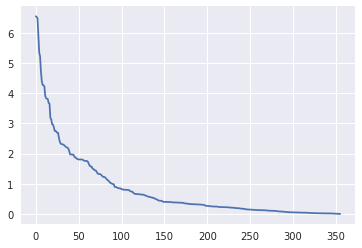

time: 255 ms


In [10]:
a = gs.best_estimator_.steps[0][1]
df_tmp = pd.DataFrame({'col':feat_numb, 'val':a.coef_})
df_tmp['abs_val'] = np.abs(df_tmp.val)
df_tmp = df_tmp.sort_values('abs_val', ascending=False).reset_index()
plt.plot(df_tmp.abs_val)
feat_numb_top150 =list(df_tmp.col[:150])
feat_numb_top200 =list(df_tmp.col[:200])

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def one_model_pred(f_predict, columns, out_file_name):
    X_stacking = np.empty(df.shape[0])
    X = df[ix_train]; print(X.shape)
    i = 0
    for train_index, test_index in kf.split(X):
        i = i + 1
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        y_pred = f_predict(X_train, y_train, X_test, columns)
        X_stacking[test_index] = y_pred
        print("Fold=",i, 'r2=',r2_score(y_test, y_pred))
    print("KFold done!")
    X_stacking[ix_test] = f_predict(df[ix_train], y, df[ix_test], feat_numb_top200)
    pd.DataFrame({'y_pred':X_stacking}).\
        to_csv("../y_pred/" + out_file_name + ".csv", index=False)
    print("Done!")
    return None

In [12]:
def xgb_fit(X_train, y_train, X_test, columns):
    num_boost_rounds = 1200
    
    xgb_params = { 
        'eta': 0.005,
        'max_depth': 4,
        'subsample': 0.8,
        'min_child_weight': 25,
        'colsample_bytree': 0.8,
        'objective': 'reg:linear',
        'eval_metric': 'rmse',
        'base_score': np.mean(y_train), # base prediction = mean(target)
        'silent': 1,
        'tree_method':'hist',
        'seed':42,
    #    'gamma': 0.05,
        'alpha':0.3
    }

    dtrain = xgb.DMatrix(X_train[columns], y_train)
    dtest = xgb.DMatrix(X_test[columns])
    
    
    # train model
    model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)
    y_pred = model.predict(dtest)
    return y_pred
    

time: 12.1 ms


In [13]:
if not os.path.isfile('./../tmp/model_score_list.pkl'):
    with open('./../tmp/model_score_list.pkl', 'wb') as f:
        pickle.dump(model_score_list, f)
    with open('./../tmp/model_pairs_list.pkl', 'wb') as f:
        pickle.dump(model_pairs_list, f)
else:
    with open('./../tmp/model_pairs_list.pkl', 'rb') as f:
        print("Load from file...")
        model_pairs_list = pickle.load(f)
    with open('./../tmp/model_score_list.pkl', 'rb') as f:
        print("Load from file...")
        model_score_list = pickle.load(f)
       

Load from file...
Load from file...
time: 105 ms


In [14]:
def woker_split(p_in):
    p = p_in.split("_")
    f1 = p[0]
    f2 = p[1]
    df[p_in] = df[f1] * df[f2]
    return p_in
df_tmp = pd.DataFrame({'scr':model_score_list}) 
top_index = df_tmp.sort_values('scr', ascending=False).\
      head(5).index
#for pairs_index in 
#_ = [woker_split(p) for p in model_pairs_list[pairs_index]]

feat_pairs_in_top = sum([model_pairs_list[ind] for ind in top_index], [])
feat_pairs_in_top = list(set(feat_pairs_in_top))

# Add pairs to train
_ = [woker_split(p) for p in feat_pairs_in_top]

time: 2.03 s


In [ ]:
one_model_pred(xgb_fit, feat_numb_top200, 'xgb_feat_numb_top200_XGB2')

(4209, 1979)
Fold= 1 r2= 0.58859745732
Fold= 2 r2= 0.438514345824
Fold= 3 r2= 0.599360604619
Fold= 4 r2= 0.61451924489
Fold= 5 r2= 0.59546423567
KFold done!
Done!
time: 13.5 s


In [ ]:
one_model_pred(xgb_fit, feat_numb, 'xgb_feat_numb_XGB')

(4209, 1979)
Fold= 1 r2= 0.587499093203
Fold= 2 r2= 0.43745087492
Fold= 3 r2= 0.599348800374
Fold= 4 r2= 0.615172320298


In [ ]:
def sgd_fit(X_train, y_train, X_test, columns):
    
    classifier = lambda: SGDRegressor(
        loss='squared_loss',
        penalty='elasticnet',
        alpha=1e-05,
        l1_ratio=1,
        fit_intercept=True,
        n_iter=5,
        shuffle=True,
        verbose=0, epsilon=0.1, random_state=42, learning_rate='invscaling',
        eta0=0.01, power_t=0.25, warm_start=False, average=False)
    
    clf = Pipeline(steps=[
        #('ss', StandardScaler()),
        ('en', classifier())
    ])
    clf.fit(X_train[columns], y_train)
    y_pred = clf.predict(X_test[columns])
    return y_pred
one_model_pred(sgd_fit, feat_numb + feat_pairs_in_top, 'sgd_feat_numb_pairs')
one_model_pred(sgd_fit, feat_numb_top200 + feat_pairs_in_top, 'sgd_feat_numb200_pairs')
one_model_pred(sgd_fit, feat_numb_top150 + feat_pairs_in_top, 'sgd_feat_numb150_150pairs')

In [ ]:
feat_list = feat_numb + feat_ohe
n_comp = 20


# PCA
pca = PCA(n_components=n_comp, random_state=42)
pca.fit(df[ix_train][feat_list])
pca2_df = pca.transform(df[feat_list])

# ICA
ica = FastICA(n_components=n_comp, random_state=42, max_iter = 600)
ica.fit(df[ix_train][feat_list])
ica2_df= ica.transform(df[feat_list])

# Append decomposition components to datasets
feat_pca = list()
feat_ica = list()
for i in range(1, n_comp+1):
    df['pca_' + str(i)] = pca2_df[:,i-1]
    df['ica_' + str(i)] = ica2_df[:,i-1]
    feat_pca.append('pca_' + str(i))
    feat_ica.append('ica_' + str(i))

In [ ]:
one_model_pred(xgb_fit, feat_pca + feat_ica + feat_numb, 'xgb_feat_numb_ica_pca')

In [ ]:
one_model_pred(xgb_fit, feat_ohe + feat_ica + feat_pca, 'xgb_feat_numb_ica_pca')
one_model_pred(xgb_fit, feat_ica + feat_pca, 'feat_ica + feat_pca')
one_model_pred(xgb_fit, feat_ohe + feat_numb_top200, 'feat_ohe + feat_numb_top200')
one_model_pred(xgb_fit, feat_ohe + feat_pairs_in_top, 'feat_ohe + feat_pairs_in_top')

In [ ]:
feat_le = list()
for col in feat_categ:
    df[col + '_le'] = LabelEncoder().fit_transform(df[col])
    feat_le.append(col + '_le')



In [ ]:
one_model_pred(xgb_fit, [feat_le[0]] + feat_numb_top150[:10], 'xgb only X0_le')

In [ ]:
one_model_pred(xgb_fit, feat_le + feat_numb_top150, 'xgb feat_le + feat_numb_top150')

In [ ]:
X = OneHotEncoder().fit_transform(df.X0_le.values.reshape(-1,1))
feat_ohe = ['X0_ohe_' + str(i) for i in np.arange(X.shape[1])]
t = pd.DataFrame(X.todense(), columns=feat_ohe, index=df.index)
df = pd.concat( [df, t] , axis=1)

In [ ]:
one_model_pred(xgb_fit, feat_ohe, 'xgb only X0_OHE')

In [ ]:
files = list(os.listdir('../y_pred'))
X = np.empty((df.shape[0],len(files)))
i = 0
for filename in files:
    X[:,i] = np.loadtxt('../y_pred/'+filename,skiprows=1)
    i = i + 1
X = StandardScaler().fit_transform(X)
    
from sklearn.linear_model import LinearRegression
#model = #LinearRegression()
model = SGDRegressor(
        loss='squared_loss',
        penalty='elasticnet',
        alpha=0.001,
        l1_ratio=1,
        fit_intercept=True,
        n_iter=5,
        shuffle=True,
        verbose=0, epsilon=0.1, random_state=42, learning_rate='invscaling',
        eta0=0.01, power_t=0.25, warm_start=False, average=False)

model.fit(X[ix_train], y)
y_sumbit = model.predict(X[ix_test])

pd.DataFrame({'ID':test.ID, 'y':y_sumbit}).to_csv("../submit/stacking_by_SGD.csv", index=False)

plt.plot(model.coef_, 'ro')

In [ ]:
files_top = np.array(files)[model.coef_ > 1]


files = files_top
X = np.empty((df.shape[0],len(files)))
i = 0
for filename in files:
    X[:,i] = np.loadtxt('../y_pred/'+filename,skiprows=1)
    i = i + 1
X = StandardScaler().fit_transform(X)
    
from sklearn.linear_model import LinearRegression
#model = #LinearRegression()
model = SGDRegressor(
        loss='squared_loss',
        penalty='elasticnet',
        alpha=0.001,
        l1_ratio=1,
        fit_intercept=True,
        n_iter=5,
        shuffle=True,
        verbose=0, epsilon=0.1, random_state=42, learning_rate='invscaling',
        eta0=0.01, power_t=0.25, warm_start=False, average=False)

model.fit(X[ix_train], y)
y_sumbit = model.predict(X[ix_test])

pd.DataFrame({'ID':test.ID, 'y':y_sumbit}).to_csv("../submit/stacking_by_SGD_files_top.csv", index=False)

plt.plot(model.coef_, 'ro')